In [2]:
import os, sys, time
sys.path.append('./')

import numpy as np
import pandas as pd
import pickle, csv
from scipy.interpolate import interp1d

from astropy import wcs
from astropy.io import fits

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import main as m
from main import spectraAna

### **STEP 1**. Open FITS image cube

In [7]:
## Open FITS image cube
fitscubename = '../data/cold_spw0.fits'
s = spectraAna(fitscubename = fitscubename)
s.readfits(verbose = False)

naxis1   = s.naxis1
naxis2   = s.naxis2
ctype3   = s.ctype3
naxis3   = s.naxis3
crpix3   = s.crpix3
cdelt3   = s.cdelt3
crval3   = s.crval3 
restfreq = s.restfreq
cube     = s.cube  ## all intensity 
freq_array = s.freq_array
velo_array = s.velo_array

### **STEP 2**.  Fitting the spectra using `gausspy`.
***STEP 2-1.*** Fit

In [ ]:
rms_spw0 = 0.0018148618
rms_spw1 = 0.0017738817
rms_spw2 = 0.0025416217
rms_spw3 = 0.0018573649

s.fit_1dgauss( cube = cube, velo=velo_array, freq=freq_array,
               spw_id = '0', rms = rms_spw0, base = 'velo',
               xrange1 = 0, xrange2 = naxis1,
               yrange1 = 0, yrange2 = naxis2  )

***STEP 2-2***. Create a dictionary to categorize pixel data based on the Gaussian fitting results— **s** for spectra fitted with a single Gaussian component, **m** for those fitted with multiple components, and **f** for those with no successful fit. Additionally, mapping these categories to their corresponding pixel positions can be helpful for debugging purposes. Include the index of each entry as well, so it aligns with the ordering of data used in the AGD algorithm.

In [8]:
spw_id = 'temp'
data = pickle.load(open(f'cube_{spw_id}.pickle','rb'))
data_decomposed = pickle.load(open(f'cube_decomposed_{spw_id}.pickle','rb'))

fit_result_dic = {'s':[], 'm':[], 'f':[]}

# The index 'i' correspond to the ordering of data and decomposed data stored by AGD algorithm
for i, (loc, ff_in_each_pixel) in enumerate(zip(data['location'], data_decomposed['means_fit'])):
    loc = tuple(loc)

    if len(ff_in_each_pixel) == 0: 
        fit_result_dic['f'].append((i, loc)) # fail
    elif len(ff_in_each_pixel) == 1: 
        fit_result_dic['s'].append((i, loc)) # single
    else: 
        fit_result_dic['m'].append((i, loc)) # multiple

A. Plot the fitting results categorized by classification (s, m, f).

In [ ]:
xvalue_array = velo_array/1e3
data_pair = {'inten':[], 'gauss':[]} 

for data_loc in fit_result_dic['m']:
    index    = data_loc[0]        
    location = data_loc[1]
    
    fit_fwhms = data_decomposed['fwhms_fit'][index]
    fit_means = data_decomposed['means_fit'][index]
    fit_amps  = data_decomposed['amplitudes_fit'][index]
    
    inten = data['data_list'][index]
    gauss = list(zip(fit_amps, fit_fwhms, fit_means))
    
    data_pair['inten'].append(inten)
    data_pair['gauss'].append(gauss)

for inten, gauss in zip(data_pair['inten'], data_pair['gauss']):
    m.plot_spectra(xvalue_array, inten, color='grey', datalabel='Data', 
                   figsize=(10,6), xlabel = 'Velocity[km/s]', gaussians=gauss)

B. Plot the spectrum of a selected pixel.

In [11]:
pixel = [ (35,66), (37,61), (39,58), (47,47), (50,40),
          (52,53), (52,89), (56,58), (72,21)
        ]

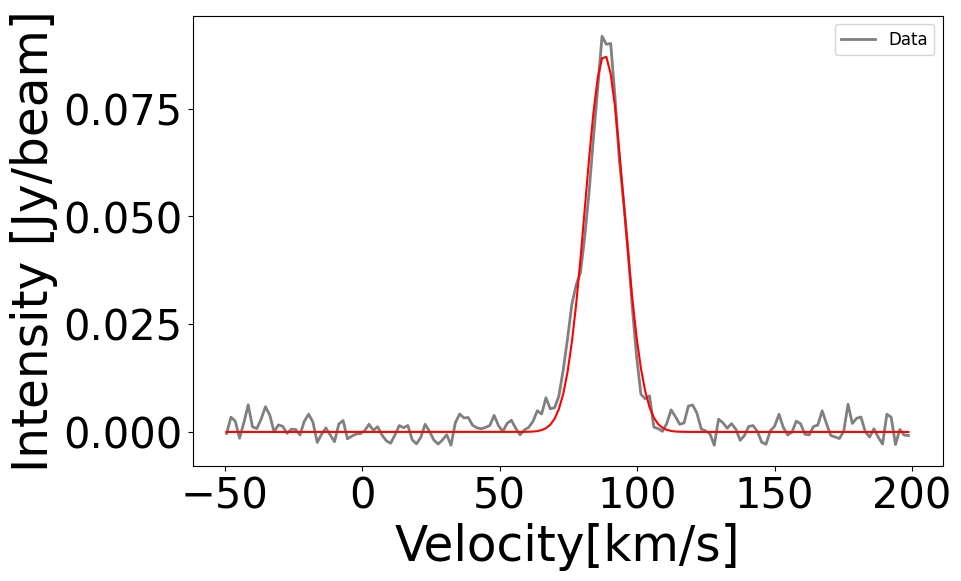

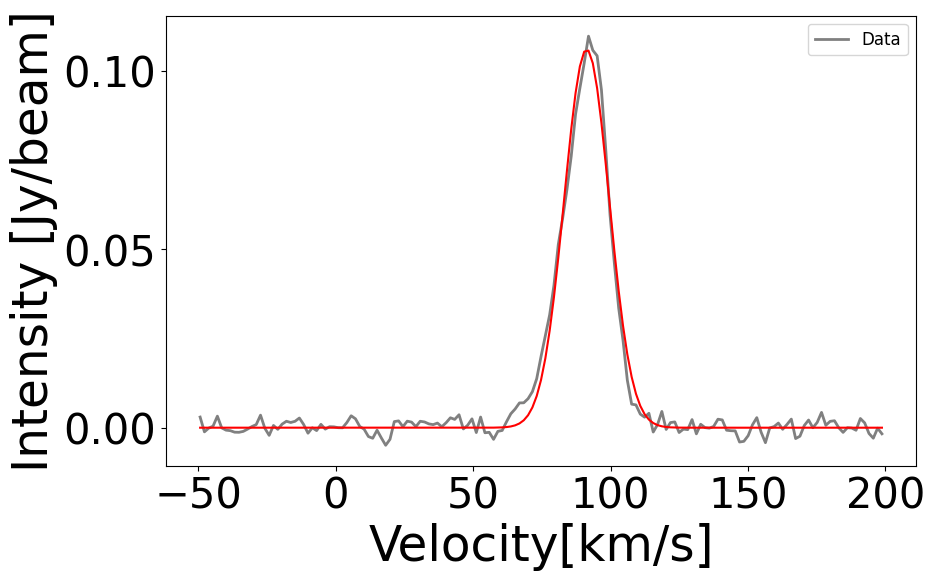

In [12]:
## Select the range of x (optional)
x_start = -50
x_end   = 200

x_startpix = np.searchsorted(velo_array, x_start*1e3) 
x_endpix   = np.searchsorted(velo_array, x_end*1e3)
sliced_x   = velo_array[x_startpix:x_endpix]

# location <-> index 
loc_dict = {tuple(loc): i for i, loc in enumerate(data['location'])}

for pix in pixel:
    if pix in loc_dict:
        i = loc_dict[pix]

        fit_fwhms = data_decomposed['fwhms_fit'][i]
        fit_means = data_decomposed['means_fit'][i]
        fit_amps  = data_decomposed['amplitudes_fit'][i]
            
        inten = data['data_list'][i]
        sliced_inten = inten[x_startpix:x_endpix]
        gauss = list(zip(fit_amps, fit_fwhms, fit_means))
            
        # output setting
        num = str(pix[0]) + str(pix[1])
        outdir = './fit_0/'
        outname = f'spw0_{num}'
        outpath = os.path.join(outdir, outname)
            
        m.plot_spectra( sliced_x/1e3, sliced_inten, 
                        figsize = (10,6), xlabel = 'Velocity[km/s]', 
                        xlabel_size = 35, ylabel_size = 35,
                        xtick_size = 30, ytick_size = 30,
                        color = 'grey', datalabel = 'Data', 
                        gaussians = gauss #, outfile = outpath
                          )

### **STEP 3**. Unredshift spectra

In [15]:
# These pixels are checked manually
fail_fit_pixels = [
            (5,0), (5,9), (6,0), (9,44), (9,55), (10,44),
            (10,55), (10,56), (11,56), (12,56), (13,57), (15,45),
            (18,88), (18,92), (18,93), (19,68), (19,88), (19,92),
            (20,31), (20,68), (20,89), (21,30), (21,52), (21,67),
            (21,68), (22,30), (30,73), (31,5), (31,6), (31,75),(85,81),
            (32,5), (32,6), (32,7), (76,75), (76,76), (76,77),(75,77),
            (76,81), (77,76), (77,77), (87,76), (88,76),(89,75),(75,76),
            (89,76), (90,75), (91,81), (93,15), (28,74), (72,85),(73,85),
            (12,57), (29,74),(30,74), (31,73),(31,74)  # m

            ]

In [16]:
shifted_x_list = []
intensity_list = []
shift_info_sio = {'delta_value':[], 'loc':[]}

for loc in fit_result_dic['s']:
    index = loc[0]
    pixel = loc[1]
    
    if pixel in fail_fit_pixels:
        shift_info_sio['delta_value'].append([]) # add empty list
        shift_info_sio['loc'].append(pixel)
        continue
    
    pixel_data = data['data_list'][index]
    fx_in_each_pixel = data_decomposed['means_fit'][index]
        
    shift_x, delta_x = s.unredshift(freq_array = freq_array,
                                    velo_array = velo_array,
                                    base = 'velo',
                                    centroid_value = fx_in_each_pixel[0],
                                    spw_restfreq = restfreq,
                                    fit_linefreq = 217.104919e9
                                    )

    shifted_x_list.append(shift_x)
    intensity_list.append(pixel_data)
    
    shift_info_sio['delta_value'].append(delta_x)
    shift_info_sio['loc'].append(pixel)
       
            
for loc in fit_result_dic['m']:
    index = loc[0]
    pixel = loc[1]
    
    if pixel in fail_fit_pixels:
        shift_info_sio['delta_value'].append([]) # add empty list
        shift_info_sio['loc'].append(pixel)
        continue
    
    pixel_data = data['data_list'][index]
    amps   = data_decomposed['amplitudes_fit'][index]
    x_fits = data_decomposed['means_fit'][index]
    
    try:
        max_index = np.argmax(amps) #Find the highest peak
        x_fit     = x_fits[max_index]
    except:
        print(f'Failed to fit in {loc}')
        continue
        
        
    shift_x, delta_x = s.unredshift(freq_array = freq_array,
                                    velo_array = velo_array,
                                    centroid_value  = x_fit,
                                    spw_restfreq = restfreq,
                                    fit_linefreq = 217.104919e9
                                    )
        
    shifted_x_list.append(shift_x)
    intensity_list.append(pixel_data)
        
    shift_info_sio['delta_value'].append(delta_x)
    shift_info_sio['loc'].append(pixel)
    
for loc in fit_result_dic['f']:
    index = loc[0]
    pixel = loc[1]
    
    shift_info_sio['delta_value'].append([]) # add empty list
    shift_info_sio['loc'].append(pixel)

filename = 'shift_info_sio.pickle'
pickle.dump(shift_info_sio, open(filename, 'wb'))

Use the velocity distribution of SO.

In [ ]:
intensity_list = []
shifted_x_list = []

xvalue_array = velo_array
shift_info_so = pickle.load(open('shift_info_so.pickle', 'rb'))

if len(data['data_list']) != len(shift_info_so['delta_value']):
    raise ValueError("Mismatch in length between data and shift_info dictionaries.")
    
else:
    shifted_x_list = [velo_array - dv for dv in shift_info_so['delta_value'] if len(dv) != 0]
    intensity_list = [data['data_list'][i] for i, dv in enumerate(shift_info_so['delta_value']) if len(dv) != 0]

### **STEP 4**. Stack spectra

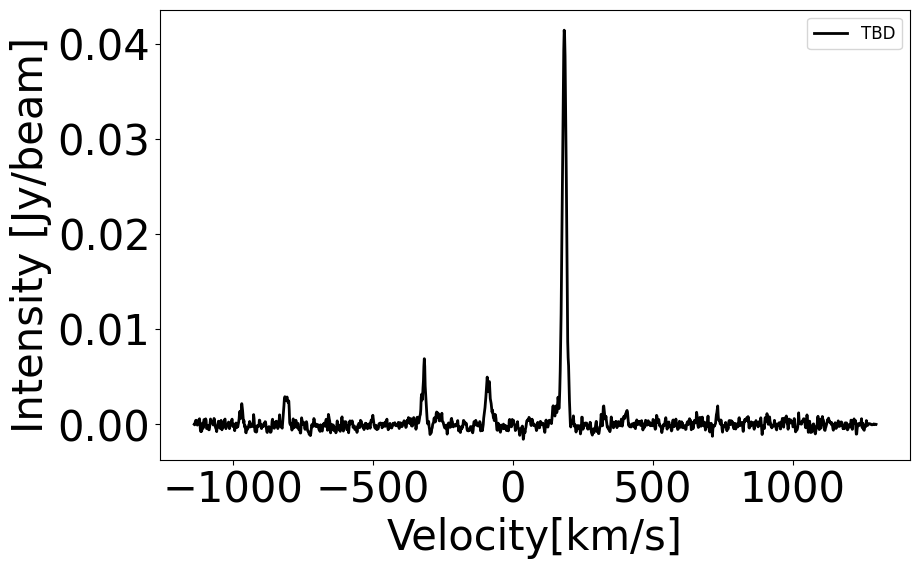

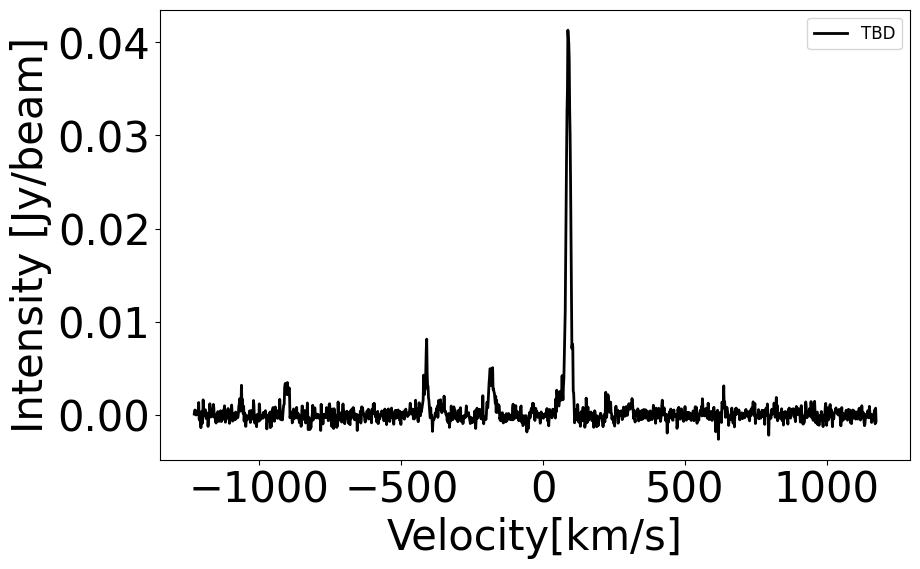

In [17]:
# create the new x_value array to cover all freq(or velo) value
minx = min(min(x) for x in shifted_x_list)
maxx = max(max(x) for x in shifted_x_list)
mean_spacing = np.mean([np.mean(np.diff(x)) for x in shifted_x_list])
points = int( (maxx - minx)/ mean_spacing)
newx_array = np.linspace(minx, maxx, points)


# stack the spectra
average_inten_shift   = s.stack_spectra(newx_array, 
                                      shifted_x_list, 
                                      intensity_list,
                                      option='unredshift')

average_inten_noshift = s.stack_spectra(newx_array, 
                                      shifted_x_list, 
                                      intensity_list, 
                                      option='redshift')

# plot the result
m.plot_spectra(newx_array/1e3, average_inten_shift, 
               figsize=(10,6), color='black',
               xlabel='Velocity[km/s]',
               xlabel_size = 30, ylabel_size = 30, 
               xtick_size  = 30, ytick_size  = 30
              )

m.plot_spectra(velo_array/1e3, average_inten_noshift, 
               figsize=(10,6), color='black',
               xlabel='Velocity[km/s]',
               xlabel_size = 30, ylabel_size = 30, 
               xtick_size  = 30, ytick_size  = 30
              )

Add the pixels which are failed to fit gaussian function

In [ ]:
sum_f_intensity = np.zeros(1532)

for loc in fit_result_dic['f']:
    index = loc[0]
    pixel = loc[1]
    
    pixel_data = data['data_list'][index]
    sum_f_intensity += pixel_data
    intensity_list.append(pixel_data)
        
interp_func_f = interp1d(velocity_array, sum_f_intensity, kind='linear', bounds_error=False, fill_value=0)
sum_f_intensity_interp = interp_func_f(newx_array)

In [ ]:
total_sum_intensity = sum_f_intensity_interp + sum_sm_intensity
length = len(intensity_list)
#print(length)
averaged_intensity = total_sum_intensity / length

m.plot_spectra(newx_array/1e3, averaged_intensity, figsize=(10,6), color='black',xlabel='Velocity[km/s]')

Generate the figure using the **sio** velocity distribution.

705 744
765 803


Text(0.03, 0.87, 'DCN (3-2)')

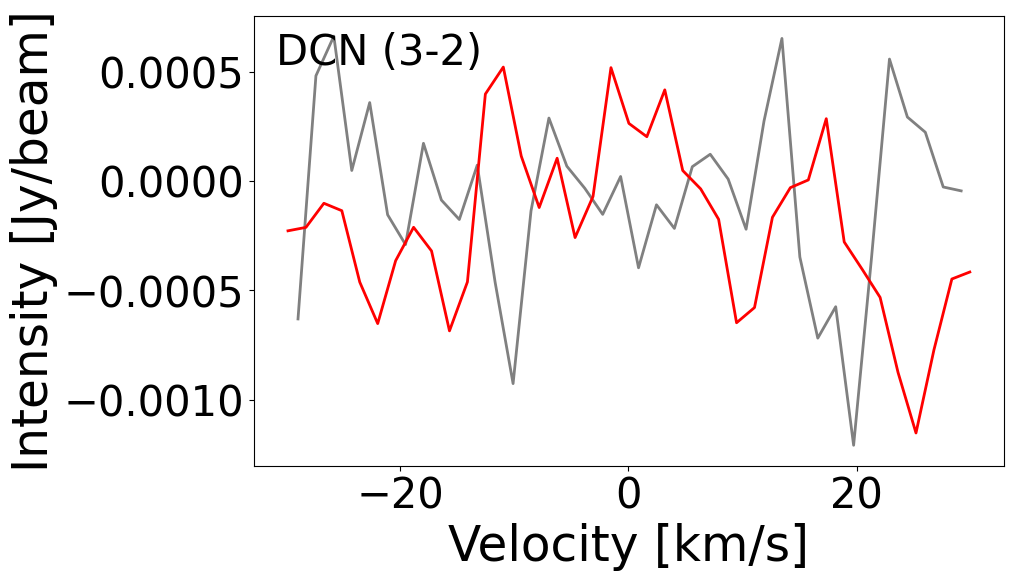

In [18]:
## View specific range (velocity in km/s, frequency in GHz)
x_start = -30
x_end   =  30

x_startpix = np.searchsorted(newx_array, x_start*1e3)
x_endpix   = np.searchsorted(newx_array, x_end*1e3)

x_start_no = np.searchsorted(velo_array, x_start*1e3) 
x_end_no   = np.searchsorted(velo_array, x_end*1e3)

print(x_startpix, x_endpix)
print(x_start_no, x_end_no)

sliced_x    = newx_array[x_startpix:x_endpix]
sliced_x_no = velo_array[x_start_no:x_end_no]
sliced_inten = average_inten_shift[x_startpix:x_endpix]
sliced_inten_noshift = average_inten_noshift[x_start_no:x_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

ax.tick_params(axis='both', labelsize=30)

plt.xlabel('Velocity [km/s]', size = 35)
plt.ylabel('Intensity [Jy/beam]', size = 35)

plt.plot(sliced_x_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_x/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)



#plt.legend(loc=1, fontsize = 10)

#plt.savefig('Stack36_0_wsio.png', bbox_inches='tight')


Figure with SO

In [ ]:
## View specific range (velocity in km/s, frequency in GHz)
x_start = -30
x_end   =  30

x_startpix = np.searchsorted(newx_array, x_start*1e3)
x_endpix   = np.searchsorted(newx_array, x_end*1e3)

x_start_no = np.searchsorted(velo_array, x_start*1e3) 
x_end_no   = np.searchsorted(velo_array, x_end*1e3)

print(x_startpix, x_endpix)
print(x_start_no, x_end_no)

sliced_x    = newx_array[x_startpix:x_endpix]
sliced_x_no = velo_array[x_start_no:x_end_no]
sliced_inten = average_inten_shift[x_startpix:x_endpix]
sliced_inten_noshift = average_inten_noshift[x_start_no:x_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

plt.xlabel('Velocity [km/s]', size = 30)
plt.ylabel('Intensity [Jy/beam]', size = 30)

plt.plot(sliced_x_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_x/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)



#plt.legend(loc=1, fontsize = 10)

#plt.savefig('Stack36_0_wso.png', bbox_inches='tight')